#### Sequential Feature Selection of PCs for Random Forest model using PV/GPH/EHF as input.

File duplicated on April 23, 2025 and localized within the H100 cluster. 
I would like to identify the # of nodes that represent >80% of the variance for each feature. Then, I will do two models. 

This one is for 10 days rather than 14. 

In [1]:
# relevant import statements
import math
import pickle
import random

##just to stop the excess number of warnings
import warnings
from random import randint, sample, seed

import cartopy.feature as cf
import cartopy.util  # Requires separate import
import matplotlib.colors as mcolors
import matplotlib.path as mpath

# plotting related imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  # statistical data visualization
import xarray as xr
from cartopy import crs as ccrs  # Useful for plotting maps
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib import rcParams  # For changing text properties
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

##import tensorflow/keras related files
import tensorflow as tf
import tensorflow.keras.backend as K
from eofs.standard import Eof
from tensorflow import keras
from tensorflow.keras import (
    Input,
    Sequential,
    constraints,
    initializers,
    layers,
    optimizers,
    regularizers,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    GRU,
    LSTM,
    Activation,
    Bidirectional,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    InputSpec,
    Layer,
    Reshape,
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# tf.compat.v1.disable_v2_behavior() # <-- HERE !


tf.compat.v1.disable_eager_execution()
import investigate

2025-04-24 00:14:29.552572: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 00:14:29.582887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-24 00:14:29.582907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 00:14:29.583709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 00:14:29.588451: I tensorflow/core/platform/cpu_feature_guar

The bulk of this file to start is copied from the previous EOF file/my EOF test file. 

##### First, I am going to pickle in the input data. I will then remove the seasonal climo from the dataset...

I had to actually download the data locally and upload it here to the H100 cluster in the ./Dissertation_Coding/data folder because I could not call it from my home directory. 

In [2]:
# load input data
infile = open("../../data/extend_pv350pt.p","rb",)
pv_input = pickle.load(infile)  ##pv on an isentropic surface, 350
infile.close()

infile = open("../../data/1959ZMeddyheatflux.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../data/1959gph.p","rb",)
gph_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [3]:
pv_input.shape  ##63 years, october through march, 16 lats (90,60), all lons.
#will need to remove the last year. 

(63, 183, 24, 181)

In [4]:
gph_input.shape

(62, 183, 37, 180)

In [5]:
#remove extra pv and gph year
pv_input = np.delete(pv_input, [62], 0)

In [6]:
ehf_input.shape

(62, 183, 37, 180)

In [7]:
pv_input.shape #again lol

(62, 183, 24, 181)

In [8]:
## remove leap day.
pv_input = np.delete(pv_input, [151], 1)
ehf_input = np.delete(ehf_input, [151], 1)
gph_input = np.delete(gph_input, [151], 1)

In [9]:
##remove seasonal climo 
def daily_anom(target):
    dailymean = np.nanmean(target, axis=1)
    anom = np.zeros_like(target)
    for t in np.arange(target.shape[1]):
        anom[:, t, :, :] = target[:, t, :, :] - dailymean
    return anom;

In [10]:
##take seasonal daily average/remove seasonal climatology
anom_pv = daily_anom(pv_input)
print("ANOM PV shape: ",anom_pv.shape)

anom_ehf = daily_anom(ehf_input)
print("ANOM EHF shape: ",anom_ehf.shape)

anom_gph = daily_anom(gph_input)
print("ANOM GPH shape: ",anom_gph.shape)

ANOM PV shape:  (62, 182, 24, 181)
ANOM EHF shape:  (62, 182, 37, 180)
ANOM GPH shape:  (62, 182, 37, 180)


In [11]:
##check for NaNs
if np.any(np.isnan(anom_pv)) or np.any(np.isinf(anom_pv)):
    print("NaN or Inf values found in PV!")

if np.any(np.isnan(anom_ehf)) or np.any(np.isinf(anom_ehf)):
    print("NaN or Inf values found in EHF!")

if np.any(np.isnan(anom_gph)) or np.any(np.isinf(anom_gph)):
    print("NaN or Inf values found in GPH!")

In [15]:
anom_pv[:62, 21:172, :, :].shape ##check date length
# anom_pv[:62,31:,:,:].shape

(62, 151, 24, 181)

In [16]:
##flatten array to just the dates relevant to my models. 
flat_anom_pv = anom_pv[:62, 21:172, :, :].reshape((62 * 151, 24, 181))
print(flat_anom_pv.shape)

flat_EHFanom = anom_ehf[:62, 21:172, :, :].reshape((62 * 151, 37, 180))
print(flat_EHFanom.shape)

flat_GPHanom = anom_gph[:62, 21:172, :, :].reshape((62 * 151, 37, 180))
print(flat_GPHanom.shape)

(9362, 24, 181)
(9362, 37, 180)
(9362, 37, 180)


#### Great, so I have everything uploaded and reduced to daily anomalies with the seasonal climo removed. Fantastic, lol. 

Now I need to weight appropriately. lol. 

I do not need to do this for EHF or GPH since I already reduced them. 

In [17]:
##I DID NOT USE THIS FOR THE EOFs, JUST TRIED TO CALCULATE HERE...
flat_anom = xr.DataArray(
    data=flat_anom_pv,
    dims=["dates", "lat", "lon"],
    coords=dict(
        dates=range(0, 9362, 1), lat=np.arange(90, 43, -2), lon=np.arange(0, 362, 2)
    ),
)
wgts = np.cos(flat_anom.lat / 180 * np.pi) ** 0.5
flat_PVanom = flat_anom * wgts
# weights=np.cos(np.deg2rad(flat_anom.lat))
# flat_anom = flat_anom.weighted(weights).mean(dim="lon").mean(dim="lat") #average over the full area
# flat_anom

In [18]:
flat_PVanom.values.shape

(9362, 24, 181)

##### Attempt at EOF analysis/PC decomp based on Zheng's example code. 

In [19]:
# EOF, the code above had selection of certain pressure levels and latitude bands. I do not need to do that here.
PVsolver = Eof(flat_PVanom.values)
EHFsolver = Eof(flat_EHFanom)
GPHsolver = Eof(flat_GPHanom)

In [20]:
print("Pickle Out Solvers ...")
pickle.dump(PVsolver, open("PVsolver_10days.p", 'wb'))
pickle.dump(EHFsolver, open("EHFsolver_10days.p", 'wb'))
pickle.dump(GPHsolver, open("GPHsolver_10days.p", 'wb'))

Pickle Out Solvers ...


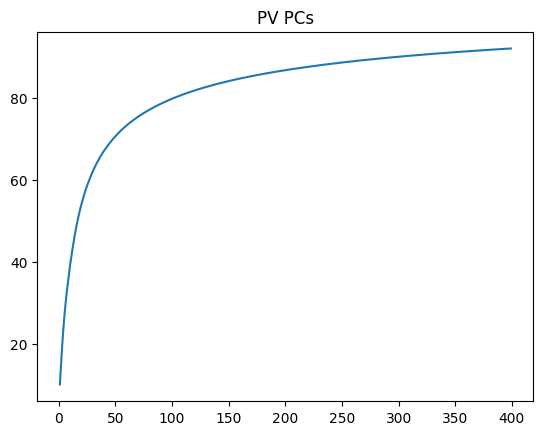

In [21]:
##loop through modes to find when highest % variance is reached for each dataset. 
variance = []
for i in range(1, 400):
    ##select the desired number of eofs
    nmode = i
    # print(nmode)
    EOF = PVsolver.eofs(neofs=nmode, eofscaling=0)
    # print(type(EOF),np.shape(EOF))
    ##make the EOF 2-dimensional
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = PVsolver.eigenvalues(neigs=nmode)
    VarEx = PVsolver.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
plt.title("PV PCs")
plt.plot(np.arange(1, 400), variance)

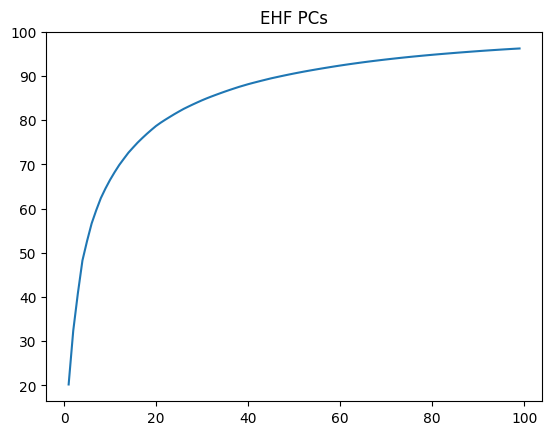

In [22]:
variance = []
for i in range(1, 100):
    ##select the desired number of eofs
    nmode = i
    # print(nmode)
    EOF = EHFsolver.eofs(neofs=nmode, eofscaling=0)
    # print(type(EOF),np.shape(EOF))
    ##make the EOF 2-dimensional
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = EHFsolver.eigenvalues(neigs=nmode)
    VarEx = EHFsolver.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
plt.title("EHF PCs")
plt.plot(np.arange(1, 100), variance)

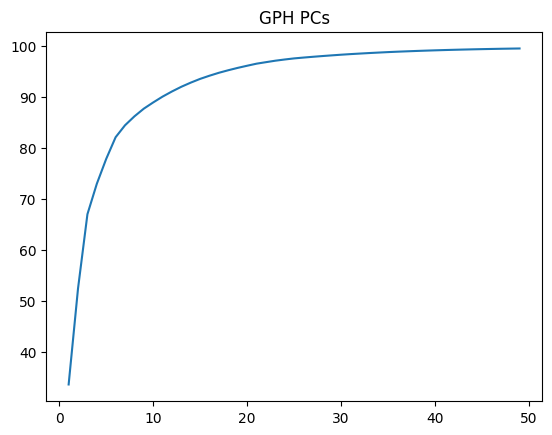

In [23]:
variance = []
for i in range(1, 50):
    ##select the desired number of eofs
    nmode = i
    # print(nmode)
    EOF = GPHsolver.eofs(neofs=nmode, eofscaling=0)
    # print(type(EOF),np.shape(EOF))
    ##make the EOF 2-dimensional
    EOF2d = EOF.reshape(EOF.shape[0], EOF.shape[-2] * EOF.shape[-1])
    # print(np.shape(EOF2d))
    pv = np.dot(EOF2d, np.transpose(EOF2d))
    EOF_nw2d = EOF2d
    # print(pv.shape)
    eigenv = GPHsolver.eigenvalues(neigs=nmode)
    VarEx = GPHsolver.varianceFraction(neigs=nmode) * 100
    variance.append(sum(VarEx))
plt.title("GPH PCs")
plt.plot(np.arange(1, 50), variance)

#### PV =| 200 PCs. 
#### EHF = 55 PCs. 
#### GPH = 12 PCs. 

Now run EOF analysis with the "correct" inital number of modes. 